In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics import roc_curve, auc
from glob import glob
from os import path


In [3]:
files_names_10 = []
for i in range(1, 11):
    files_names_10.append(glob('./messages/part%d/*.txt' % i))

max_n = 3
n_gramms = [np.array([]) for i in range(max_n)]
folds_n = [[] for i in range(max_n)]

for n in range(max_n):
    for i in range(10):
        fold = np.empty((0, 2))
        for file_name in files_names_10[i]:
            with open(file_name, 'r') as msg_file:
                subject = msg_file.readline().lstrip('Subject:').split()
                subject = [subject[n_i:] for n_i in range(n+1)]
                subject = np.array(list(map(' '.join, zip(*subject))))
                if subject.ndim == 1:
                    subject = subject[None]
                msg_file.readline()
                message = msg_file.readline().split()
                message = [message[n_i:] for n_i in range(n+1)]
                message = np.array(list(map(' '.join, (zip(*message)))))
                X = np.append(subject, message)
                label = re.findall(r'\d+([A-Za-z]+)\d+', path.basename(file_name))[0]
                fold = np.append(fold, np.array([X, label])[None], axis=0)
                n_gramms[n] = np.append(n_gramms[n], X)
        folds_n[n].append(fold)
    n_gramms[n] = np.unique(n_gramms[n])

<ipython-input-3-265728aa3aa1>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fold = np.append(fold, np.array([X, label])[None], axis=0)


In [4]:
def count_p(x_one_hot, y_train, class_probs, classes, lamd):
    classes_prob = (y_train.reshape((-1, 1)) == classes).sum(axis=0)/y_train.size
    return lamd * classes_prob +\
           np.log(class_probs[:, x_one_hot == 1]).sum(axis=1) + np.log(1 - class_probs[:, x_one_hot == 0]).sum(axis=1)

In [5]:
def predict_proba(X, X_train, y_train, n_gramm, classes, alpha, lamd):
    class_probs = np.empty((classes.size, n_gramm.size))
    X_train_one_hot = np.apply_along_axis(lambda a, b: np.in1d(b, a[0]), 0, X_train[None], n_gramm).astype(np.uint8).T
    X_one_hot = np.apply_along_axis(lambda a, b: np.in1d(b, a[0]), 0, X, n_gramm).astype(np.uint8).T
    for i in range(classes.size):
        c_indexes = np.where(y_train == classes[i])[0]
        c_count =  (y_train == classes[i]).sum()
        c_words_count = X_train_one_hot[c_indexes].sum(axis=0)
        class_probs[i] = (c_words_count + alpha)/(c_count + 2*alpha)
    pred_prob = np.apply_along_axis(count_p, 1, X_one_hot, y_train, class_probs, classes, lamd)
    return pred_prob/np.abs(pred_prob).sum(axis=1)[None].T

In [6]:
def predict(X, X_train, y_train, n_gramm, alpha, lamd):
    classes = np.unique(y_train)
    return classes[np.argmax(predict_proba(X, X_train, y_train, n_gramm, classes, alpha, lamd), axis=1)]

In [7]:
def cf_matrix(X_test, y_test, X_train, y_train, classes, n_gramm, alpha, lamd):
    pred = predict(X_test, X_train, y_train, n_gramm, alpha, lamd)
    res = np.empty((classes.size, classes.size))
    for i in range(classes.size):
        for j in range(classes.size):
            res[i, j] = (np.all((pred == classes[i], y_test == classes[j]), axis=0)).sum()
    return res

In [8]:
def k_fold_average_cf(folds, n_gramm, alpha, classes, lamd, k=10, plot_roc=False):
    res = np.full((classes.size, classes.size), 0.)
    if plot_roc:
        fig, ax = plt.subplots()
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

    for i in range(k):
        X_train = np.array([])
        y_train = np.array([])
        for j in np.concatenate((np.arange(i), np.arange(i+1, k))):
            X_train = np.append(X_train, folds[j][:, 0][None])
            y_train = np.append(y_train, folds[j][:, 1])
        X_test = folds[i][:, 0][None]
        y_test = folds[i][:, 1]
        res += cf_matrix(X_test, y_test, X_train, y_train, classes, n_gramm, alpha, lamd)/k
        if plot_roc:
            scores = predict_proba(X_test, X_train, y_train ,n_gramm, classes, alpha, lamd)[:, 0]
            fpr, tpr, _ = roc_curve(y_test, scores, pos_label='legit')
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc(fpr, tpr))

    if plot_roc:
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
               title='ROC n: %d | alpha: %.2f | legit lambda: %.2f , spam lambda: %.2f' % (n+1, alpha, lamd[0], lamd[1]))
        ax.legend(loc="lower right")
        plt.show()

    return res

In [9]:
classes = np.array(['legit', 'spmsg'])

In [10]:
def test(n, alpha_range=[1e-3], lamd_range=[1], k=10, verbose=False, plot=True):
    tps = np.array([])
    fps = np.array([])
    fns = np.array([])
    tns = np.array([])
    lamd_legits = []
    for alpha in alpha_range:
        for lamd_legit in lamd_range:
            lamd_legits.append(lamd_legit)
            [[tp, fp], [fn,tn]] = k_fold_average_cf(folds_n[n], n_gramms[n], alpha, classes, np.array([lamd_legit, lamd_range[0]]), k=k)
            if verbose:
                print(
                    '\n n:', n+1, 'k:', k, '\n',
                    'alpha:', alpha, 'legit lambda:', lamd_legit,'\n',
                    '%2.2f %2.2f\n %2.2f %2.2f' % (tp, fp, fn, tn), '\n',
                    'accuracy: %.2f' % ((tp+ tn)/(tp + tn + fp + fn)),
                    '\n' + ''.join(['-']*20),
                )
            tps = np.append(tps, tp)
            fps = np.append(fps, fp)
            fns = np.append(fns, fn)
            tns = np.append(tns, tn)
            if fn == 0:
                k_fold_average_cf(folds_n[n], n_gramms[n], alpha, classes, np.array([lamd_legit, lamd_range[0]]), k=k, plot_roc=plot)
                break
        if plot:
            accuracies = (tps+ tns)/(tps + tns + fps + fns)
            plt.plot(lamd_legits, accuracies, label='n: %d' % (n+1))
            plt.title('n: %d | alpha: %.2f' % (n, alpha))
            plt.ylabel('accuracy')
            plt.xlabel('legit lambda')
            plt.show()

### Для n=1

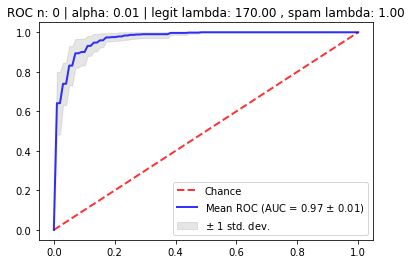

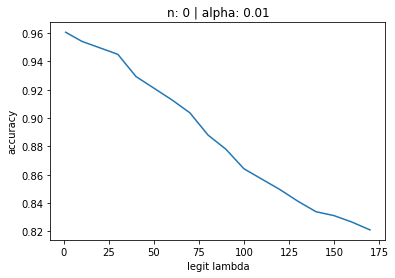

In [304]:
test(0, [0.01], [1] + list(range(10, 10001, 10)))

### Для n=2

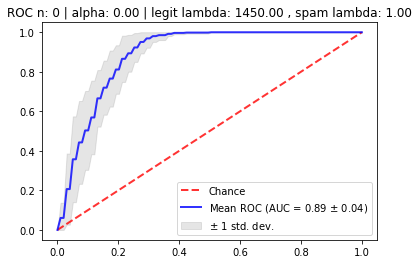

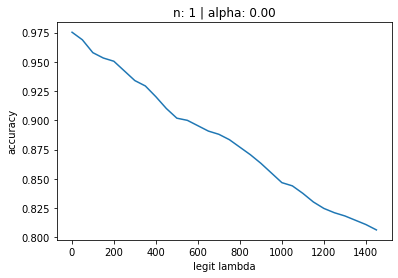

In [306]:
test(1, [1e-7], [1] + list(range(50, 10001, 50)))

### Для n=3


 n: 3 k: 10 
 alpha: 1e-13 legit lambda: 1 
 60.20 2.60
 0.80 45.40 
 accuracy: 0.97 
--------------------

 n: 3 k: 10 
 alpha: 1e-13 legit lambda: 1000 
 60.80 11.80
 0.20 36.20 
 accuracy: 0.89 
--------------------

 n: 3 k: 10 
 alpha: 1e-13 legit lambda: 2000 
 61.00 16.20
 0.00 31.80 
 accuracy: 0.85 
--------------------


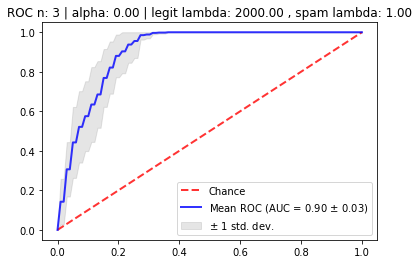

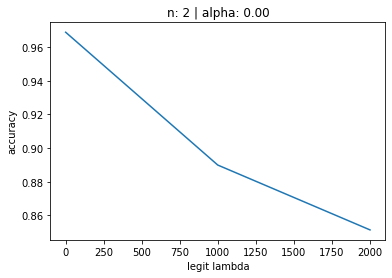

In [12]:
test(2, [1e-13], [1] + list(range(1000, 10001, 1000)), verbose=True)
